## Lag Correlation Analysis and Granger Causality Test

This notebook analyze the relationship between Nvidia's stock opening prices and news sentiment over time, focusing on whether news sentiment can help predict stock price movements.

### Raw opening price vs sentiment score

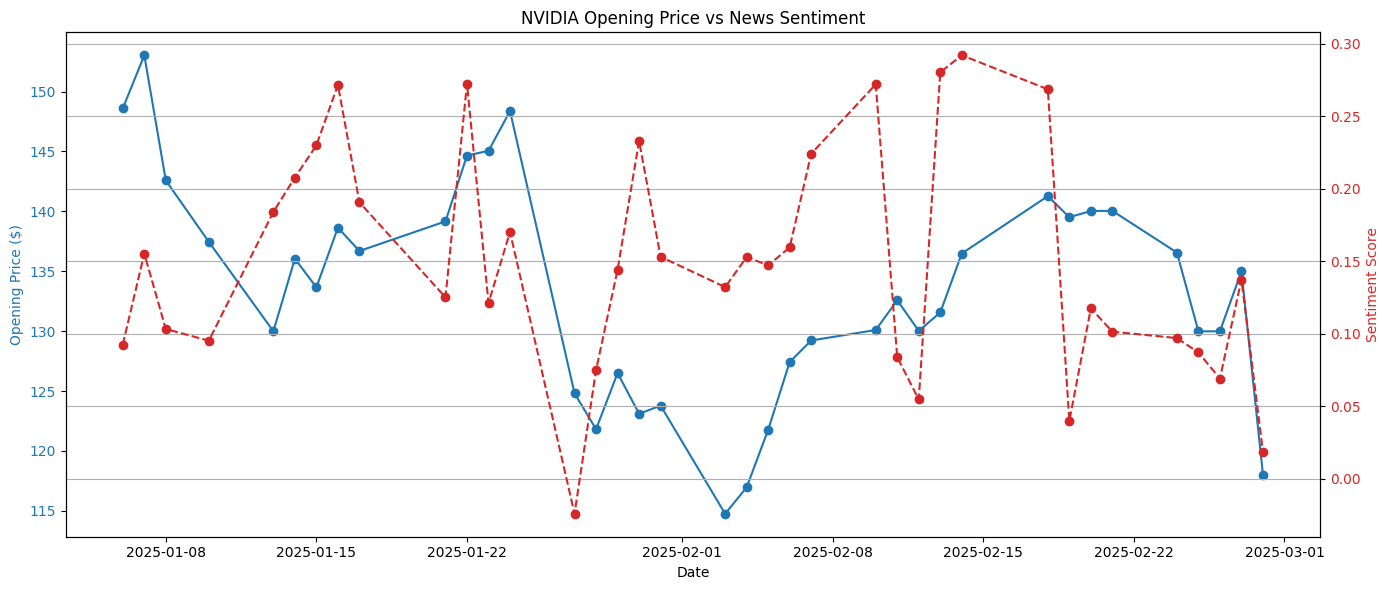

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# load datasets
prices_df = pd.read_csv("../data/nvda_open_prices.csv", parse_dates=["date"])
sentiment_df = pd.read_csv("../data/nvda_sentiment_scores.csv", parse_dates=["date"]) # test with nvda_finbert_sentiment_scores.csv

# merge datasets on date
merged_df = pd.merge(prices_df, sentiment_df, on="date")

# plot opening price and sentiment score on two y-axis
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("Opening Price ($)", color=color)
ax1.plot(merged_df["date"], merged_df["open_price"], color=color, label="Open Price", marker = 'o')
ax1.tick_params(axis='y', labelcolor=color)

# create second y-axis for sentiment score
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Sentiment Score", color=color)
ax2.plot(merged_df["date"], merged_df["sentiment_score"], color=color, linestyle='--', label="Sentiment Score", marker = 'o')
ax2.tick_params(axis='y', labelcolor=color)

# title and legend
plt.title("NVIDIA Opening Price vs News Sentiment")
fig.tight_layout()
plt.grid(True)

# save plot
plt.savefig('../outputs/nvda_open_price_vs_sentiment.png')

plt.show()

#### *Comments*
Both opening price and sentiment score are very noisy with short-term fluctuations, making it difficult to see meaningful patterns. However, some potential correlations are visible upon visual inspection. For example, around January 22 and the days following, both sentiment and opening price experienced a brief upward trend. This was followed by a simultaneous decline in both metrics over the subsequent days.

### 5-day moving average of sentiment score vs 5-day moving average of opening price

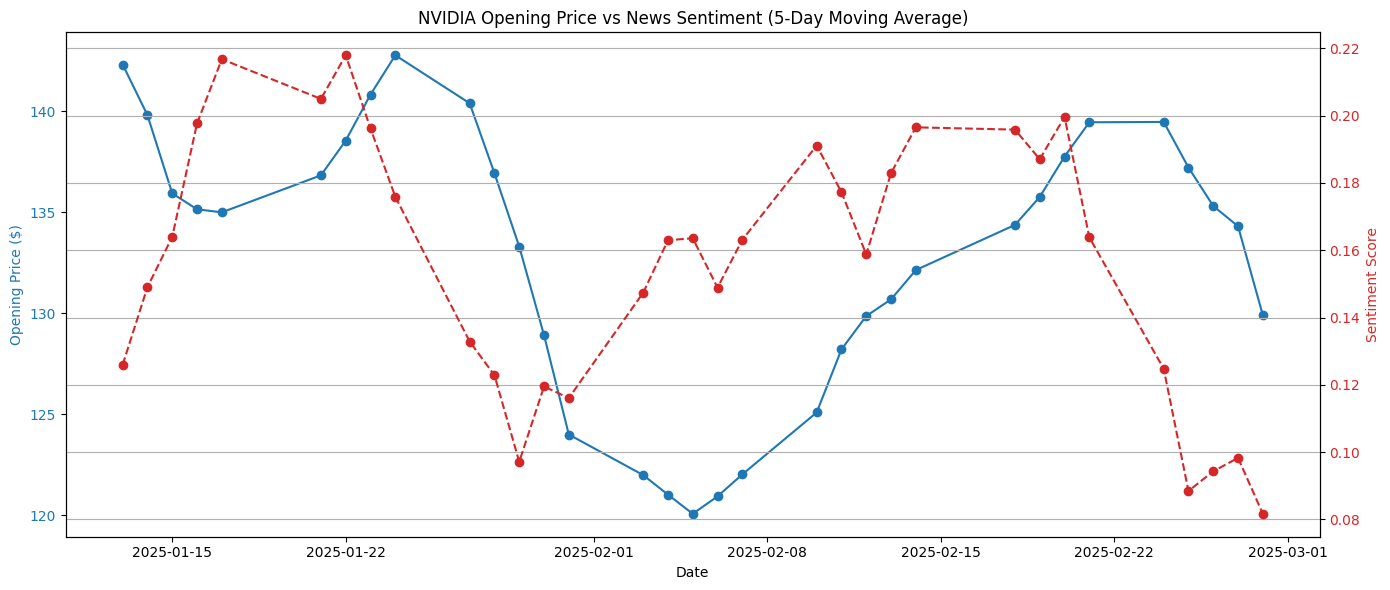

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# load datasets
prices_df = pd.read_csv("../data/nvda_open_prices.csv", parse_dates=["date"])
sentiment_df = pd.read_csv("../data/nvda_sentiment_scores.csv", parse_dates=["date"])

# merge on date
merged_df = pd.merge(prices_df, sentiment_df, on="date")

# sort by date just in case
merged_df = merged_df.sort_values("date")

# apply 5-day moving average
merged_df["open_price_ma5"] = merged_df["open_price"].rolling(window=5).mean()
merged_df["sentiment_score_ma5"] = merged_df["sentiment_score"].rolling(window=5).mean()

# plotting
fig, ax1 = plt.subplots(figsize=(14, 6))

# plot 5-day moving average of opening price
color = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("Opening Price ($)", color=color)
ax1.plot(merged_df["date"], merged_df["open_price_ma5"], color=color, label="Open Price (5D MA)", marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# create second y-axis for sentiment score
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Sentiment Score", color=color)
ax2.plot(merged_df["date"], merged_df["sentiment_score_ma5"], color=color, linestyle='--', label="Sentiment Score (5D MA)", marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# title and legend
plt.title("NVIDIA Opening Price vs News Sentiment (5-Day Moving Average)")
fig.tight_layout()
plt.grid(True)

# save plot
plt.savefig('../outputs/nvda_open_price_vs_sentiment_5-day_ma.png')

plt.show()

#### *Comments*
Applying a 5-day moving average smooths out the short-term fluctuations in both sentiment score and stock price, making broader trends more apparent. This technique helps reduce noise and highlights meaningful movements. Financial time series data are often volatile on a day-to-day basis, so using a short moving average like 5 days is effective for preserving underlying trends while filtering out minor anomalies. The 5-day window was chosen due to the relatively small dataset, which spans approximately 8 weeks.

### Lag correlation and Granger causality analysis on smoothed NVDA open prices and sentiment scores using a 5-day moving average

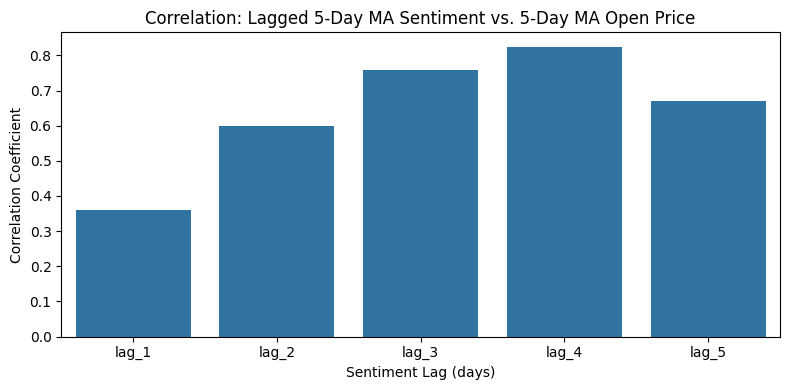

Lag Correlations:
lag_1: 0.3614
lag_2: 0.5997
lag_3: 0.7592
lag_4: 0.8244
lag_5: 0.6716

--- Granger Causality Test Results (5-Day MA) ---

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=55.4672 , p=0.0000  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=62.4006 , p=0.0000  , df=1
likelihood ratio test: chi2=32.3268 , p=0.0000  , df=1
parameter F test:         F=55.4672 , p=0.0000  , df_denom=24, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6683  , p=0.0928  , df_denom=21, df_num=2
ssr based chi2 test:   chi2=6.6071  , p=0.0368  , df=2
likelihood ratio test: chi2=5.8873  , p=0.0527  , df=2
parameter F test:         F=2.6683  , p=0.0928  , df_denom=21, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1857  , p=0.3431  , df_denom=18, df_num=3
ssr based chi2 test:   chi2=4.9405  , p=0.1762  , df=3
likelihood ratio test: chi2=4.5084  , p=0.2115  , df=3
parameter F test:         F=1.185

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

# suppress warnings about deprecated features for cleaner output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# load NVDA open price and sentiment score data, parsing 'date' as a datetime object
open_prices_df = pd.read_csv("../data/nvda_open_prices.csv", parse_dates=["date"])
sentiment_scores_df = pd.read_csv("../data/nvda_sentiment_scores.csv", parse_dates=["date"])

# merge and sort by date
merged_df = pd.merge(open_prices_df, sentiment_scores_df, on="date").sort_values("date")

# apply 5-day moving averages
merged_df["open_price_ma"] = merged_df["open_price"].rolling(window=5).mean()
merged_df["sentiment_score_ma"] = merged_df["sentiment_score"].rolling(window=5).mean()

# drop NaNs from moving average windows at the beginning
merged_df = merged_df.dropna().copy()

# create lagged sentiment MA features (1–5 days)
for lag in range(1, 6):
    merged_df[f"sentiment_score_ma_lag{lag}"] = merged_df["sentiment_score_ma"].shift(lag)

# drop NaNs resulting from lagging process
lagged_df = merged_df.dropna().copy()

# compute correlation between open price MA and each lagged sentiment MA
correlations = {
    f"lag_{lag}": lagged_df["open_price_ma"].corr(lagged_df[f"sentiment_score_ma_lag{lag}"])
    for lag in range(1, 6)
}

# plot lag correlations
plt.figure(figsize=(8, 4))
sns.barplot(x=list(correlations.keys()), y=list(correlations.values()))
plt.title("Correlation: Lagged 5-Day MA Sentiment vs. 5-Day MA Open Price")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Sentiment Lag (days)")
plt.tight_layout()

# save lag correlation plot
plt.savefig('../outputs/lag_correlation_sentiment_open_price.png')

plt.show()

# print correlation results
print("Lag Correlations:")
for lag, value in correlations.items():
    print(f"{lag}: {value:.4f}")

# prepare data for Granger causality test
granger_df = lagged_df[["open_price_ma", "sentiment_score_ma"]]

# run Granger causality test
print("\n--- Granger Causality Test Results (5-Day MA) ---")
granger_results = grangercausalitytests(granger_df, maxlag=5, verbose=True)

#### *Comments*
Two key tasks were performed:

1. __Lag correlation analysis__: this calculates the correlation between the stock price and lagged sentiment scores (lags of 1 to 5 days). The purpose is to check if past sentiment can explain current stock price

2. __Granger causality test__: a Granger causality test was performed to determine if lagged sentiment (from 1 to 5 days) has predictive power over the stock price

The lagged correlations show a gradual increase in correlation from lag 1 (0.361) to lag 4 (0.824), which suggests that past sentiment has a growing influence on the stock price over time. In other words, sentiment from a few days ago is highly correlated with today's opening price. However, the correlation weakens at lag 5, indicating that sentiment may have a shorter predictive window.

The Granger causality results reveal that there is significant causality at lag 1, suggesting that current sentiment can indeed help predict the next day's stock price. Very strong evidence (p-value < 0.01) that sentiment Granger-cause price.

### Lag correlation and Granger causality analysis on percentage changes in smoothed NVDA open prices and sentiment scores (5-day moving average)

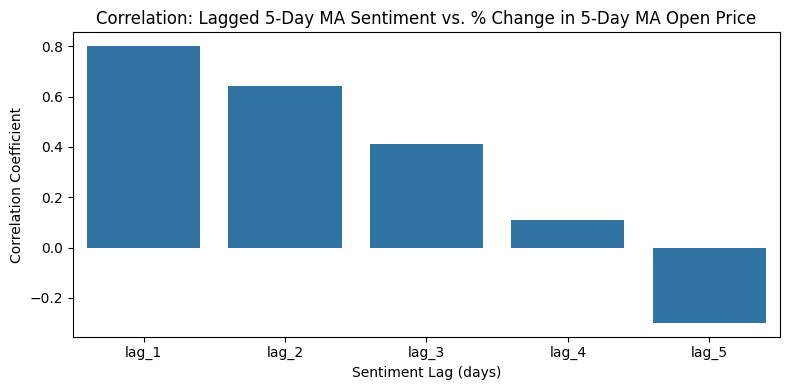

Lagged Correlation Coefficients:
lag_1: 0.8001
lag_2: 0.6405
lag_3: 0.4125
lag_4: 0.1109
lag_5: -0.2985

--- Granger Causality Test Results ---

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7938  , p=0.0245  , df_denom=23, df_num=1
ssr based chi2 test:   chi2=6.5495  , p=0.0105  , df=1
likelihood ratio test: chi2=5.8413  , p=0.0157  , df=1
parameter F test:         F=5.7938  , p=0.0245  , df_denom=23, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6068  , p=0.0986  , df_denom=20, df_num=2
ssr based chi2 test:   chi2=6.5170  , p=0.0384  , df=2
likelihood ratio test: chi2=5.7913  , p=0.0553  , df=2
parameter F test:         F=2.6068  , p=0.0986  , df_denom=20, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6862  , p=0.2076  , df_denom=17, df_num=3
ssr based chi2 test:   chi2=7.1417  , p=0.0675  , df=3
likelihood ratio test: chi2=6.2518  , p=0.1000  , df=3
parameter F test:         F=

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

# suppress warnings about deprecated features for cleaner output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# load NVDA open price and sentiment score data, parsing 'date' as a datetime object
open_prices_df = pd.read_csv("../data/nvda_open_prices.csv", parse_dates=["date"])
sentiment_scores_df = pd.read_csv("../data/nvda_sentiment_scores.csv", parse_dates=["date"])

# merge and sort by date
merged_df = pd.merge(open_prices_df, sentiment_scores_df, on="date").sort_values("date")

# apply 5-day moving averages
merged_df["open_price_ma"] = merged_df["open_price"].rolling(window=5).mean()
merged_df["sentiment_score_ma"] = merged_df["sentiment_score"].rolling(window=5).mean()

# drop NaNs from moving average windows at the beginning
merged_df = merged_df.dropna().copy()

# calculate % change in the moving average open price
merged_df["pct_change_open_price_ma"] = merged_df["open_price_ma"].pct_change() * 100

# drop NaNs caused by the percent change calculation
merged_df = merged_df.dropna().copy()

# create lagged sentiment MA features (1–5 days)
for lag in range(1, 6):
    merged_df[f"sentiment_score_ma_lag{lag}"] = merged_df["sentiment_score_ma"].shift(lag)

# drop remaining NaNs resulting from lagging process
lagged_df = merged_df.dropna().copy()

# compute correlation between % change in open price and each lagged sentiment score
correlations = {
    f"lag_{lag}": lagged_df["pct_change_open_price_ma"].corr(lagged_df[f"sentiment_score_ma_lag{lag}"])
    for lag in range(1, 6)
}

# plot lag correlation
plt.figure(figsize=(8, 4))
sns.barplot(x=list(correlations.keys()), y=list(correlations.values()))
plt.title("Correlation: Lagged 5-Day MA Sentiment vs. % Change in 5-Day MA Open Price")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Sentiment Lag (days)")
plt.tight_layout()

# save lag correlation plot
plt.savefig('../outputs/lag_correlation_sentiment_pct_change.png')

plt.show()

# print correlation results
print("Lagged Correlation Coefficients:")
for lag, value in correlations.items():
    print(f"{lag}: {value:.4f}")

# prepare data for Granger causality test
# format must be [dependent_variable, independent_variable]
granger_df = lagged_df[["pct_change_open_price_ma", "sentiment_score_ma"]]

# run Granger causality test
print("\n--- Granger Causality Test Results ---")
granger_results = grangercausalitytests(granger_df, maxlag=5, verbose=True)

#### *Comments*
To better focus on relative price movements, this analysis also examines percentage changes in the 5-day moving average of stock prices. This transformation shifts the focus from absolute price levels to trends and volatility.

The correlation between lagged sentiment (moving average) and the percentage change in price (moving average) is calculated to assess whether past sentiment influences the rate of price change.

Granger causality tests are again conducted, this time using percentage changes instead of raw prices. This approach provides insight into how sentiment may drive price momentum and market shifts.

At lag 1, a strong correlation (0.8001) is observed, indicating a significant relationship between prior-day sentiment and the next day’s percentage price change. The Granger causality test also confirms a statistically significant effect at lag 1 (p-value = 0.0245), reinforcing the idea that sentiment can be a useful predictor of short-term price movements.

### Conclusion

The findings suggest that news sentiment has an impact on Nvidia stock, with the strongest correlation and causality observed at lag 1 (yesterday's news, or news published after the last trading day and leading up to the next trading day) is a statistically significant predictor for today's opening price change.